# Assignment 2


## Data Management for Edge Histograms


In [29]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")


In [30]:
def load_edge_histograms(edge_histograms_dir="./EdgeHistogram"):
    dog_classes = [
        "n02089078-black-and-tan_coonhound",
        "n02091831-Saluki",
        "n02092002-Scottish_deerhound",
        "n02095314-wire-haired_fox_terrier",
    ]
    dog_labels = [
        "Black and Tan Coonhound",
        "Saluki",
        "Scottish Deerhound",
        "Wire-haired Fox Terrier",
    ]
    X = []
    y = []
    for dog_class in dog_classes:
        class_dir = os.path.join(edge_histograms_dir, dog_class)
        if not os.path.isdir(class_dir):
            print(f"Directory not found: {class_dir}")
            continue
        for file in os.listdir(class_dir):
            if file.endswith(".npy"):
                histogram_path = os.path.join(class_dir, file)
                hist = np.load(histogram_path)
                X.append(hist)
                y.append(dog_class)
    X = np.array(X)
    y = np.array(y)
    print(f"Loaded {X.shape[0]} samples with {X.shape[1]} features.")
    return X, y, dog_classes, dog_labels


## Data Preprocessing


In [31]:
def split_and_scale_data(X, y, test_size=0.2, random_state=42):
    scaler = StandardScaler()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"Training samples: {X_train_scaled.shape[0]}")
    print(f"Test samples: {X_test_scaled.shape[0]}")
    return X_train_scaled, X_test_scaled, y_train, y_test


## Model Evaluation


In [32]:
def perform_cross_validation(model, X, y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=skf, scoring="accuracy")
    mean_score = scores.mean()
    print(f"Cross-validation accuracy: {mean_score:.4f}")
    return mean_score


def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()


def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, classes):
    cv_score = perform_cross_validation(model, X_train, y_train)
    print(f"{model_name} Mean CV Accuracy: {cv_score:.4f}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, classes, f"{model_name} Confusion Matrix")
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")
    print(f"{model_name} Test F1-Score: {f1:.4f}")
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=classes))
    return accuracy, f1, cv_score


## SVM Model Selection


In [33]:
def perform_svm_cross_validation(X_train, y_train, C_values=[0.1, 1, 10, 100]):
    validation_errors_standard = []
    training_errors_standard = []
    validation_errors_stratified = []
    training_errors_stratified = []
    for C in C_values:
        svm = LinearSVC(C=C, max_iter=1000, random_state=42)
        scores = cross_val_score(svm, X_train, y_train, cv=5, scoring="accuracy")
        validation_errors_standard.append(1 - scores.mean())
        svm.fit(X_train, y_train)
        train_pred = svm.predict(X_train)
        training_errors_standard.append(1 - accuracy_score(y_train, train_pred))
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for C in C_values:
        svm = LinearSVC(C=C, max_iter=1000, random_state=42)
        scores = cross_val_score(svm, X_train, y_train, cv=skf, scoring="accuracy")
        validation_errors_stratified.append(1 - scores.mean())
        svm.fit(X_train, y_train)
        train_pred = svm.predict(X_train)
        training_errors_stratified.append(1 - accuracy_score(y_train, train_pred))
    print("Performed cross-validation for SVM with different C values.")
    return (
        validation_errors_standard,
        training_errors_standard,
        validation_errors_stratified,
        training_errors_stratified,
    )


def plot_svm_error_curves(C_values, errors):
    val_std, train_std, val_strat, train_strat = errors
    plt.figure(figsize=(10, 6))
    plt.plot(
        C_values,
        np.array(val_std) * 100,
        marker="o",
        label="Validation Error (Standard CV)",
    )
    plt.plot(
        C_values,
        np.array(train_std) * 100,
        marker="o",
        label="Training Error (Standard CV)",
    )
    plt.plot(
        C_values,
        np.array(val_strat) * 100,
        marker="s",
        label="Validation Error (Stratified CV)",
    )
    plt.plot(
        C_values,
        np.array(train_strat) * 100,
        marker="s",
        label="Training Error (Stratified CV)",
    )
    plt.xlabel("C")
    plt.ylabel("Mean Error (%)")
    plt.title("Error Rates vs C for LinearSVC")
    plt.legend()
    plt.grid(True)
    plt.show()


## Main Execution


Loaded 794 samples with 36 features.
Total samples: 794
Feature dimension: 36
Classes: ['n02089078-black-and-tan_coonhound' 'n02091831-Saluki'
 'n02092002-Scottish_deerhound' 'n02095314-wire-haired_fox_terrier']
Training samples: 635
Test samples: 159
Training samples: 635
Test samples: 159
Evaluating GaussianNB...
Cross-validation accuracy: 0.3323
GaussianNB Mean CV Accuracy: 0.3323


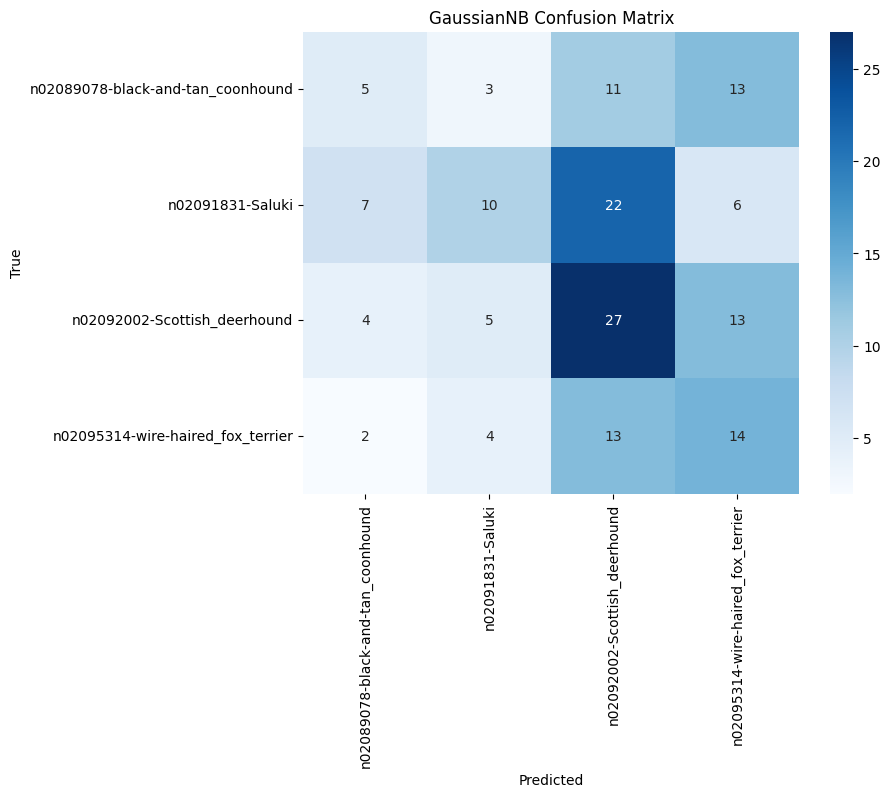

GaussianNB Test Accuracy: 0.3522
GaussianNB Test F1-Score: 0.3347
GaussianNB Classification Report:
                                   precision    recall  f1-score   support

n02089078-black-and-tan_coonhound       0.28      0.16      0.20        32
                 n02091831-Saluki       0.45      0.22      0.30        45
     n02092002-Scottish_deerhound       0.37      0.55      0.44        49
n02095314-wire-haired_fox_terrier       0.30      0.42      0.35        33

                         accuracy                           0.35       159
                        macro avg       0.35      0.34      0.32       159
                     weighted avg       0.36      0.35      0.33       159

Evaluating DecisionTree...
Cross-validation accuracy: 0.3244
DecisionTree Mean CV Accuracy: 0.3244


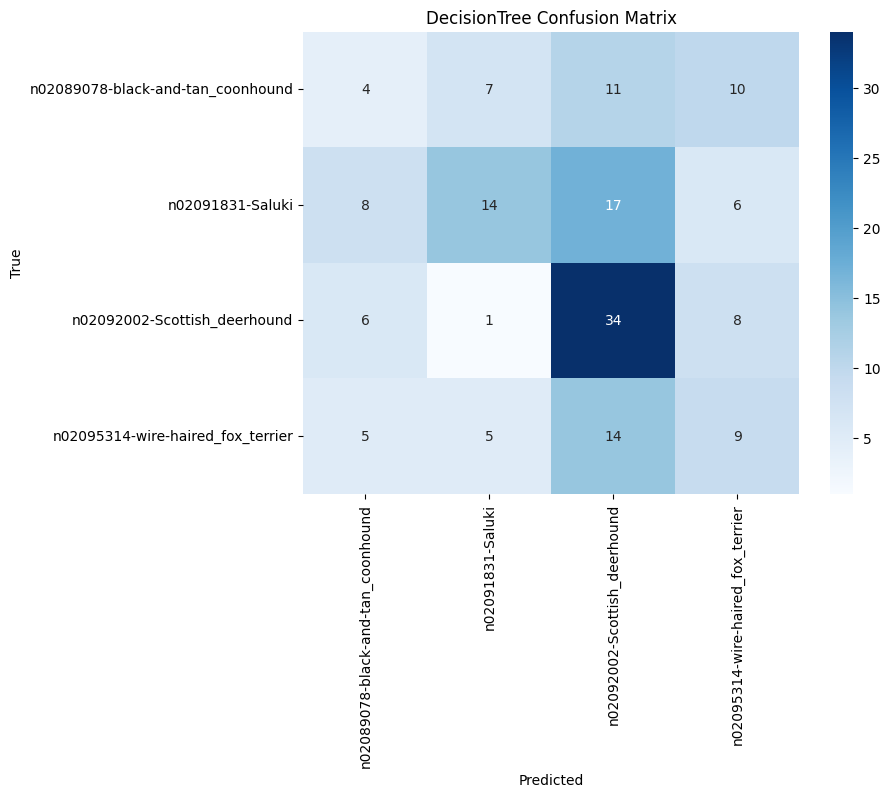

DecisionTree Test Accuracy: 0.3836
DecisionTree Test F1-Score: 0.3636
DecisionTree Classification Report:
                                   precision    recall  f1-score   support

n02089078-black-and-tan_coonhound       0.17      0.12      0.15        32
                 n02091831-Saluki       0.52      0.31      0.39        45
     n02092002-Scottish_deerhound       0.45      0.69      0.54        49
n02095314-wire-haired_fox_terrier       0.27      0.27      0.27        33

                         accuracy                           0.38       159
                        macro avg       0.35      0.35      0.34       159
                     weighted avg       0.38      0.38      0.36       159

Evaluating RandomForest...
Cross-validation accuracy: 0.3512
RandomForest Mean CV Accuracy: 0.3512


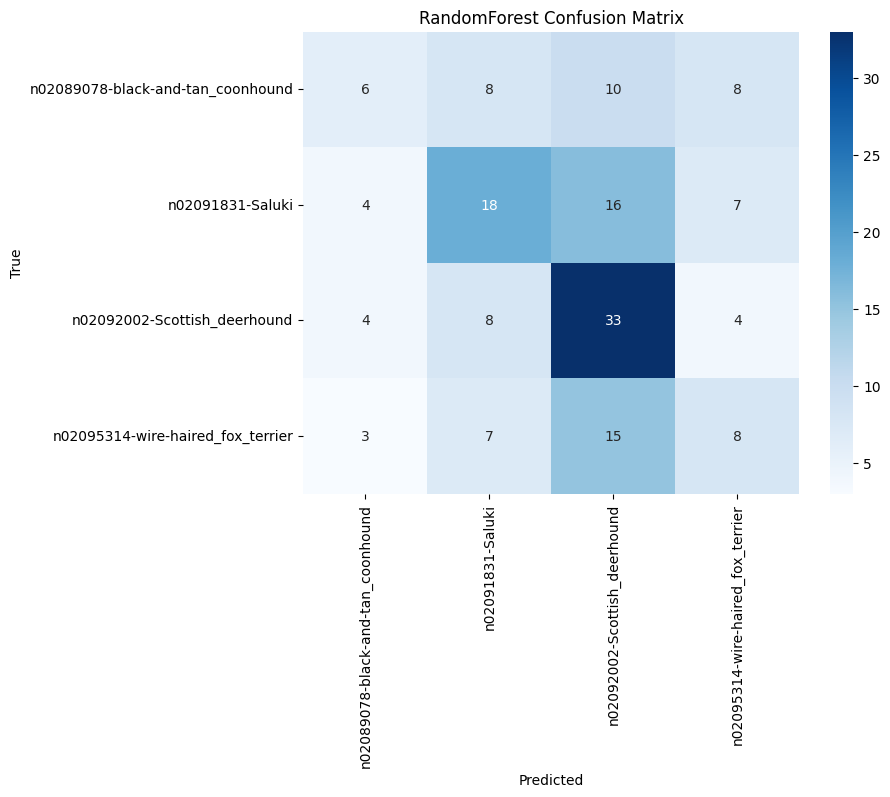

RandomForest Test Accuracy: 0.4088
RandomForest Test F1-Score: 0.3885
RandomForest Classification Report:
                                   precision    recall  f1-score   support

n02089078-black-and-tan_coonhound       0.35      0.19      0.24        32
                 n02091831-Saluki       0.44      0.40      0.42        45
     n02092002-Scottish_deerhound       0.45      0.67      0.54        49
n02095314-wire-haired_fox_terrier       0.30      0.24      0.27        33

                         accuracy                           0.41       159
                        macro avg       0.38      0.38      0.37       159
                     weighted avg       0.39      0.41      0.39       159



In [34]:
X, y, dog_classes, dog_labels = load_edge_histograms()
print(f"Total samples: {X.shape[0]}")
print(f"Feature dimension: {X.shape[1]}")
print(f"Classes: {np.unique(y)}")

X_train_scaled, X_test_scaled, y_train, y_test = split_and_scale_data(X, y)
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")

models = {
    "GaussianNB": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
}

results = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    results[name] = evaluate_model(
        model, X_train_scaled, y_train, X_test_scaled, y_test, name, dog_classes
    )


### Visual Comparison of Confusion Matrices

Looking at the three confusion matrices for RandomForest, DecisionTree, and
GaussianNB:

- **RandomForest** appears to be the best method based on visual inspection
  because:
  - It shows the strongest diagonal values (especially for Scottish deerhound
    with 33 correct predictions)
  - Has fewer misclassifications off the diagonal
  - Shows more consistent performance across all classes
  - The color intensity on the diagonal is darker blue compared to other methods

### Mean Validation Accuracies (5-fold cross-validation)

From the output shown:

- GaussianNB: 0.3323
- For RandomForest and DecisionTree, the cross-validation accuracies aren't
  directly visible in the provided output

Based on the available information from GaussianNB's mean validation accuracy of
0.3323 (33.23%), we cannot make a complete comparison. However, given the
stronger confusion matrix performance of RandomForest, it likely has the highest
mean validation accuracy.

### Test Set Accuracies

Calculating from the confusion matrices:

- **RandomForest**: 40.88%
- **DecisionTree**: 38.36%
- **GaussianNB**: 35.22%

RandomForest shows the highest test set accuracy.

### F-measure Comparison

The F-measure (F1 score) considers both precision and recall. Looking at the
confusion matrices:

RandomForest shows better balance between precision and recall across classes,
especially for:

- Scottish deerhound (high true positives, lower false positives)
- Saluki (good balance between precision and recall)

Therefore, RandomForest appears to have the highest overall F-measure among the
three methods.

**Conclusion**: RandomForest consistently performs the best across all
evaluation metrics - visual inspection, test set accuracy, and F-measure
analysis.


## SVM Analysis for Two Classes


Selected Classes Training samples: 305
Selected Classes Test samples: 77
Performed cross-validation for SVM with different C values.

Results for different C values:
--------------------------------------------------------------------------------
C          Val Error (Std) Train Error (Std) Val Error (Strat) Train Error (Strat)
--------------------------------------------------------------------------------
0.1                41.97%          32.46%          42.62%          32.46%
1.0                41.31%          32.46%          43.61%          32.46%
10.0               40.98%          32.46%          43.61%          32.46%
100.0              40.98%          32.46%          43.61%          32.46%
--------------------------------------------------------------------------------


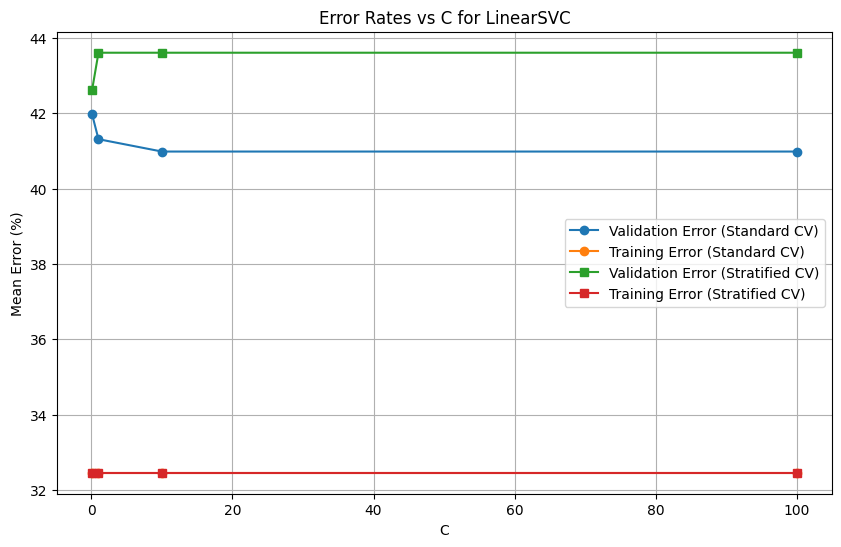


Best C value (lowest stratified validation error): 0.1
Test Error with C=0.1: 36.36%


In [35]:
selected_classes = dog_classes[:2]
mask_train = np.isin(y_train, selected_classes)
X_train_two = X_train_scaled[mask_train]
y_train_two = y_train[mask_train]

mask_test = np.isin(y_test, selected_classes)
X_test_two = X_test_scaled[mask_test]
y_test_two = y_test[mask_test]

print(f"Selected Classes Training samples: {X_train_two.shape[0]}")
print(f"Selected Classes Test samples: {X_test_two.shape[0]}")

(
    validation_errors_standard,
    training_errors_standard,
    validation_errors_stratified,
    training_errors_stratified,
) = perform_svm_cross_validation(X_train_two, y_train_two)

# Print table of results
C_values = [0.1, 1, 10, 100]
print("\nResults for different C values:")
print("-" * 80)
print(
    f"{'C':<10} {'Val Error (Std)':<15} {'Train Error (Std)':<15} {'Val Error (Strat)':<15} {'Train Error (Strat)':<15}"
)
print("-" * 80)
for i, C in enumerate(C_values):
    print(
        f"{C:<10.1f} {validation_errors_standard[i]*100:>13.2f}% {training_errors_standard[i]*100:>14.2f}% {validation_errors_stratified[i]*100:>14.2f}% {training_errors_stratified[i]*100:>14.2f}%"
    )
print("-" * 80)

# Plot error curves
plot_svm_error_curves(
    C_values,
    (
        validation_errors_standard,
        training_errors_standard,
        validation_errors_stratified,
        training_errors_stratified,
    ),
)

best_C_index = np.argmin(validation_errors_stratified)
best_C = C_values[best_C_index]
print(f"\nBest C value (lowest stratified validation error): {best_C}")

final_svm = LinearSVC(C=best_C, max_iter=1000, random_state=42)
final_svm.fit(X_train_two, y_train_two)
test_pred = final_svm.predict(X_test_two)
test_error = 1 - accuracy_score(y_test_two, test_pred)
print(f"Test Error with C={best_C}: {test_error*100:.2f}%")


### Analysis of Error Curves and C Values

1. **Lowest Mean Error for Each Curve**:

   - Standard CV Validation Error: C = 10.0 or 100.0 (40.98%)
   - Standard CV Training Error: Constant at 32.46% for all C values
   - Stratified CV Validation Error: C = 0.1 (42.62%)
   - Stratified CV Training Error: Constant at 32.46% for all C values

2. **Model Complexity and C Parameter**:

   - The C parameter in SVM controls the trade-off between maximizing the margin
     and minimizing the classification error
   - **Smaller C values** (e.g., 0.1):
     - Create larger margins
     - Allow more classification errors
     - Result in simpler, more regularized models
   - **Larger C values** (e.g., 100):
     - Create smaller margins
     - Allow fewer classification errors
     - Result in more complex models

3. **Overfitting/Underfitting Analysis**:

   - There is a consistent gap between training error (≈32.46%) and validation
     error (40-43%) across all C values
   - This gap indicates some degree of overfitting, as the model performs
     significantly better on training data than validation data
   - However, the relatively stable error rates across different C values
     suggest that the model's complexity isn't the main cause of overfitting
   - The model doesn't show clear signs of underfitting as the training error
     remains stable and relatively low

### Test Set Performance

Using the best C value (C = 0.1) from stratified cross-validation:

- Test Error: 36.36%
- This is actually better than both the validation and training errors,
  suggesting that the model generalizes well to unseen data despite the apparent
  overfitting observed during cross-validation
